<a href="https://colab.research.google.com/github/MaksonViini/Hackhaton-BNDES/blob/develop/BNDES_Cluster_operacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_parquet('/content/drive/Shareddrives/bndes-arquivos/operacoes-coops.parquet')
df_ativos = pd.read_parquet('/content/drive/Shareddrives/bndes-arquivos/cnpj-ativas_coop.parquet')
df_join = pd.read_parquet('/content/drive/Shareddrives/bndes-arquivos/cross-table.parquet')

In [ ]:
df.shape

(102085, 9)

In [ ]:
df_ativos.shape

(22078, 15)

In [ ]:
df_ativos.head()

,cnpj_base,cnpj_ordem,cnpj_dv,situacao_data,atividade_inicio,cnae_principal,cep,uf,municipio,cnae_descricao,natureza,capital_social,porte_empresa,natureza_descricao,id
0,77890846,0054,80,2016-12-01,2016-12-01,4632003,21011690,RJ,6001,Comércio atacadista de cereais e leguminosas b...,2143,0.0,demais,Cooperativa,908460054RJ
1,26656128,0001,00,2016-12-01,2016-12-01,5211701,98590000,RS,8859,Armazéns gerais - emissão de warrant,2143,32000.0,demais,Cooperativa,561280001RS
2,22753982,0013,69,2016-12-01,2016-12-01,6424703,35700481,MG,5343,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,539820013MG
3,46844338,0044,60,2016-12-01,2016-12-01,4731800,19960000,SP,6297,Comércio varejista de combustíveis para veícul...,2143,0.0,demais,Cooperativa,443380044SP
4,26706113,0001,09,2016-12-01,2016-12-01,4744001,89908000,SC,8299,Comércio varejista de ferragens e ferramentas,2143,2850.0,demais,Cooperativa,061130001SC


In [ ]:
df_ativos['porte_empresa'].value_counts()

demais                      22058
nao informado                  17
empresa de pequeno porte        3
Name: porte_empresa, dtype: int64

In [ ]:
df.head()

,cliente,cnpj,uf,municipio,municipio_codigo,data_da_contratacao,valor_em_reais,valor_desembolsado_reais,fonte_de_recurso_desembolsos,custo_financeiro,juros,prazo_carencia_meses,prazo_amortizacao_meses,modalidade_de_apoio,forma_de_apoio,produto,instrumento_financeiro,inovacao,area_operacional,setor_cnae,subsetor_cnae_agrupado,subsetor_cnae_codigo,subsetor_cnae_nome,setor_bndes,subsetor_bndes,porte_do_cliente,natureza_do_cliente,instituicao_financeira_credenciada,cnpj_do_agente_financeiro,situacao,origem,valor_contratado_reais,descricao_do_projeto,numero_do_contrato,tipo_de_garantia,tipo_de_excepcionalidade,id
0,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,SP,PEDREGULHO,3537008,2002-01-02,16000.0,16000.0,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",24,36,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,16000.0,0,0,0,0,382320001SP
1,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,BA,MEDEIROS NETO,2921104,2002-01-02,30447.0,30447.0,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",24,36,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,30447.0,0,0,0,0,382320001BA
2,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,CAMPOS ALTOS,3111507,2002-01-02,5000.0,5000.0,RECURSOS VINCULADOS - FAT DEPA“SITOS ESPECIAIS,TAXA FIXA,"4,0",12,54,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,PRONAF INVESTIMENTO,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0100000,"AGRICULTURA, PECUARIA E SERVICOS RELACIONADOS",AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,5000.0,0,0,0,0,382320001MG
3,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,CAPITAO ANDRADE,3112653,2002-01-02,25000.0,25000.0,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",0,60,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,25000.0,0,0,0,0,382320001MG
4,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,RO,SAO FELIPE D'OESTE,1101484,2002-01-02,20326.0,20326.0,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",12,48,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,20326.0,0,0,0,0,382320001RO


In [ ]:
df_join[['municipio_codigo', 'cep']]

,municipio_codigo,cep
0,3111507,35534000
1,3112653,35534000
2,3153400,35534000
3,3168606,35534000
4,3168606,35534000
...,...,...
16537,3126208,38690000
16538,3126208,38690000
16539,3111507,38970000
16540,4318804,96170000


In [4]:
df1 = df.select_dtypes(np.number)

In [5]:
dfx = df1.drop(['municipio_codigo', 'numero_do_contrato', 'valor_desembolsado_reais'], axis=1)

In [ ]:
dfx.corr()

,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais
valor_em_reais,1.000000,0.081633,-0.025509,0.553035
prazo_carencia_meses,0.081633,1.000000,0.043349,0.045565
prazo_amortizacao_meses,-0.025509,0.043349,1.000000,-0.113839
valor_contratado_reais,0.553035,0.045565,-0.113839,1.000000


In [ ]:
exploration = pd.DataFrame({
    'column': dfx.columns, 'type': dfx.dtypes, 'NA #': dfx.isna().sum(), 'NA %': round((dfx.isna().sum() / dfx.shape[0]) * 100, 2)
})
exploration.sort_values('NA %', ascending=False)

,column,type,NA #,NA %
valor_em_reais,valor_em_reais,float64,0,0.0
prazo_carencia_meses,prazo_carencia_meses,int32,0,0.0
prazo_amortizacao_meses,prazo_amortizacao_meses,int32,0,0.0
valor_contratado_reais,valor_contratado_reais,float64,0,0.0


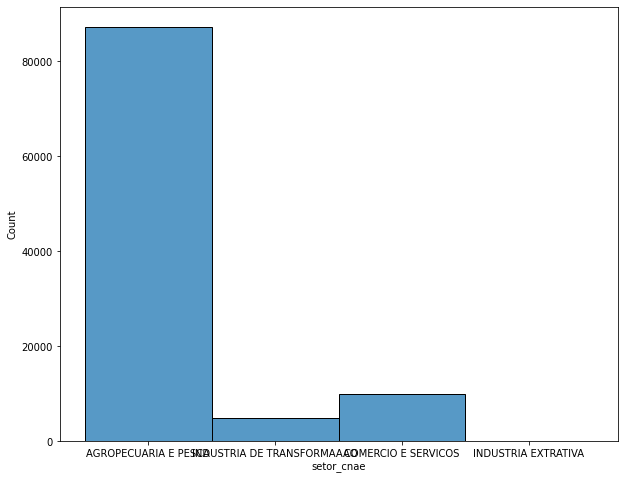

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(x='setor_cnae', data=df)

In [6]:
col = ['cliente', 'setor_cnae', 'porte_do_cliente', 'juros']

# Data Transform

In [7]:
data = df[col] 

In [8]:
data = pd.concat([df[col], dfx], axis=1)

In [ ]:
data

,cliente,setor_cnae,porte_do_cliente,juros,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais
0,BANCO COOPERATIVO SICOOB S.A.,AGROPECUARIA E PESCA,MICRO,"8,75",16000.0,24,36,16000.0
1,BANCO COOPERATIVO SICOOB S.A.,AGROPECUARIA E PESCA,MICRO,"8,75",30447.0,24,36,30447.0
2,BANCO COOPERATIVO SICOOB S.A.,AGROPECUARIA E PESCA,MICRO,"4,0",5000.0,12,54,5000.0
3,BANCO COOPERATIVO SICOOB S.A.,AGROPECUARIA E PESCA,MICRO,"8,75",25000.0,0,60,25000.0
4,BANCO COOPERATIVO SICOOB S.A.,AGROPECUARIA E PESCA,MICRO,"8,75",20326.0,12,48,20326.0
...,...,...,...,...,...,...,...,...
102080,COOPERATIVA AGROINDUSTRIAL ALFA,INDUSTRIA DE TRANSFORMAAAO,GRANDE,"2,25",62533000.0,36,84,0.0
102081,COOPERATIVA AGROINDUSTRIAL ALFA,INDUSTRIA DE TRANSFORMAAAO,GRANDE,"7,0",14644000.0,36,84,0.0
102082,COOPERATIVA AGROINDUSTRIAL ALFA,INDUSTRIA DE TRANSFORMAAAO,GRANDE,"7,0",60000000.0,36,84,0.0
102083,UNIMED FORTALEZA SOCIEDADE COOPERATIVA MEDICA ...,COMERCIO E SERVICOS,GRANDE,"1,49",100000000.0,24,72,0.0


In [ ]:
df['setor_cnae'].unique()

array(['AGROPECUARIA E PESCA', 'INDUSTRIA DE TRANSFORMAAAO',
       'COMERCIO E SERVICOS', 'INDUSTRIA EXTRATIVA'], dtype=object)

In [9]:
func_porte = lambda x: (0 if x == 'MICRO' else 
                        1 if x == 'PEQUENA' else
                        2 if x == 'MADIA' else
                        3)

func_setor = lambda x: (0 if x == 'AGROPECUARIA E PESCA' else 
                        1 if x == 'INDUSTRIA DE TRANSFORMAAAO' else
                        2 if x == 'COMERCIO E SERVICOS' else 
                        3)

# func_natureza_cliente = lambda x: (0 if x == 'PRIVADA' else
#                                    1 if x == 'ADMINISTRAAAO PAsBLICA DIRETA - GOVERNO MUNICIPAL' else
#                                    2 if x == 'PAsBLICA INDIRETA' else
#                                    3 if x == 'ADMINISTRAAAO PAsBLICA DIRETA - GOVERNO ESTADUAL' else 
#                                    4)
replace = lambda x: x.replace(',', '.')

In [10]:
data['porte_do_cliente'] = data['porte_do_cliente'].apply(func_porte)
data['setor_cnae'] = data['setor_cnae'].apply(func_setor)
data['juros'] = data['juros'].apply(replace)
data['juros'] = data['juros'].astype(np.number)

In [ ]:
data['setor_cnae'].unique()

array([0, 1, 2, 3])

In [ ]:
data.dtypes

cliente                     object
setor_cnae                   int64
porte_do_cliente             int64
juros                      float64
valor_em_reais             float64
prazo_carencia_meses         int32
prazo_amortizacao_meses      int32
valor_contratado_reais     float64
dtype: object

# Model 

In [13]:
X = data.drop('cliente', axis=1)

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

In [ ]:
wcss = calculate_wcss(X)

In [ ]:
number = list(range(2, 21))

fig = go.Figure(data = go.Scatter(x=number, y=wcss))

fig.update_layout(title='WCSS vs. Cluster number',
                   xaxis_title='Clusters',
                   yaxis_title='WCSS')
fig.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

In [ ]:
X_clusted = kmeans.predict(X)

In [ ]:
data['label'] = X_clusted

In [ ]:
data.head()

,cliente,setor_cnae,porte_do_cliente,juros,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais,label
0,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,16000.0,24,36,16000.0,2
1,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,30447.0,24,36,30447.0,2
2,BANCO COOPERATIVO SICOOB S.A.,0,0,4.00,5000.0,12,54,5000.0,2
3,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,25000.0,0,60,25000.0,2
4,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,20326.0,12,48,20326.0,2


In [ ]:
data['valor_em_reais'].max()

183837000.0

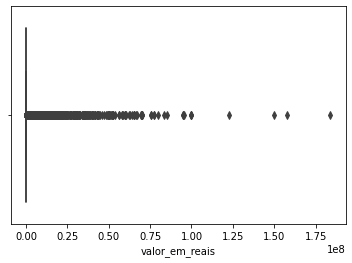

In [ ]:
sns.boxplot(x='valor_em_reais', data=data)

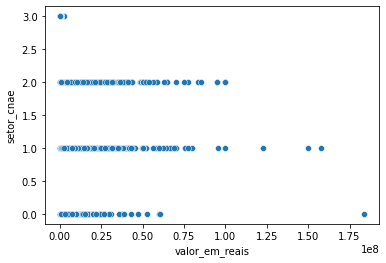

In [ ]:
sns.scatterplot(x='valor_em_reais', y='setor_cnae', data=data)

In [ ]:
dtx['valor_em_reais'].median()

269973.0

In [ ]:
dtx['valor_em_reais'].min()

10000.0

In [ ]:
 data.groupby('setor_cnae')['label'].value_counts()

setor_cnae  label
0           0        46028
            2        36577
            1         3874
            3          597
1           1         3335
            3          888
            0          468
            2          232
2           1         8465
            3         1556
            0           13
            2           13
3           1           39
Name: label, dtype: int64

In [ ]:
data['label'].value_counts()

0    46509
2    36822
1    15713
3     3041
Name: label, dtype: int64

In [ ]:
data['label'].value_counts()

1    14741
0     1309
2      368
3      124
Name: label, dtype: int64

# PCA Plot

In [11]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_pca)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



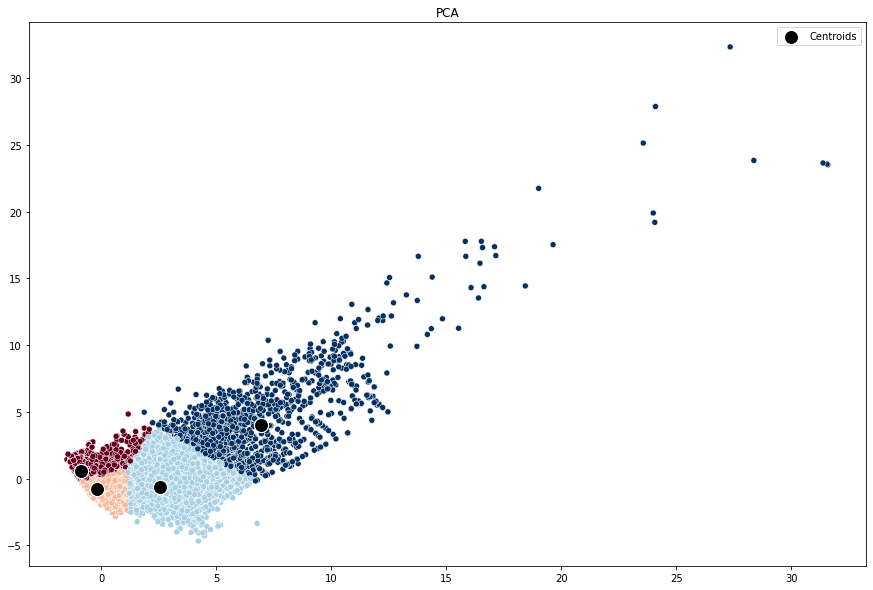

In [17]:
sns.color_palette("tab10")
plt.figure(figsize=(15, 10))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='RdBu')
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, color='black', label='Centroids')
plt.title('PCA')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

for i in range(2, 11):
    clusterer = KMeans(n_clusters=i)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    print('Silhueta para ' + str(i) + ' clusters : ' + str(score))

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
data.head()

,cliente,setor_cnae,porte_do_cliente,juros,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais,label
0,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,16000.0,24,36,16000.0,2
1,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,30447.0,24,36,30447.0,2
2,BANCO COOPERATIVO SICOOB S.A.,0,0,4.00,5000.0,12,54,5000.0,2
3,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,25000.0,0,60,25000.0,2
4,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,20326.0,12,48,20326.0,2


In [ ]:
data.shape

(102085, 9)

In [ ]:
df_join.shape

(16542, 54)

In [ ]:
data['id'] = df['id']

In [ ]:
data.head()

,cliente,setor_cnae,porte_do_cliente,juros,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais,label,id
0,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,16000.0,24,36,16000.0,0,382320001SP
1,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,30447.0,24,36,30447.0,0,382320001BA
2,BANCO COOPERATIVO SICOOB S.A.,0,0,4.00,5000.0,12,54,5000.0,0,382320001MG
3,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,25000.0,0,60,25000.0,0,382320001MG
4,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,20326.0,12,48,20326.0,0,382320001RO


In [ ]:
data.to_csv('/content/drive/Shareddrives/bndes-arquivos/operacoes_cluster.csv', index=False)

# Model Test

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_op = pd.read_csv('/content/drive/Shareddrives/bndes-arquivos/operacoes_cluster.csv')
df_cross = pd.read_parquet('/content/drive/Shareddrives/bndes-arquivos/cross-table.parquet')
label = pd.read_excel('/content/drive/Shareddrives/bndes-arquivos/cross-table-rene.xlsx')

In [ ]:
label.head()

,id,cliente,cnpj,uf,municipio,municipio_codigo,data_da_contratacao,valor_em_reais,valor_desembolsado_reais,fonte_de_recurso_desembolsos,custo_financeiro,juros,prazo_carencia_meses,prazo_amortizacao_meses,modalidade_de_apoio,forma_de_apoio,produto,instrumento_financeiro,inovacao,area_operacional,setor_cnae,subsetor_cnae_agrupado,subsetor_cnae_codigo,subsetor_cnae_nome,setor_bndes,subsetor_bndes,porte_do_cliente,natureza_do_cliente,instituicao_financeira_credenciada,cnpj_do_agente_financeiro,situacao,origem,valor_contratado_reais,descricao_do_projeto,numero_do_contrato,tipo_de_garantia,tipo_de_excepcionalidade,cnpj_base,cnpj_ordem,cnpj_dv,situacao_data,atividade_inicio,cnae_principal,cep,municipio (#1),cnae_descricao,natureza,capital_social,porte_empresa,natureza_descricao,nome_empresarial,cnae_secundario,label
0,382320001MG,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,CAMPOS ALTOS,3111507,2002-01-02,5000,5000,RECURSOS VINCULADOS - FAT DEPA“SITOS ESPECIAIS,TAXA FIXA,"4,0",12,54,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,PRONAF INVESTIMENTO,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0100000,"AGRICULTURA, PECUARIA E SERVICOS RELACIONADOS",AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,5000,0,0,0,0,71238232,1,20,2005-11-01,1993-08-01,6424703,35534000,4289,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,COOPERATIVA DE CREDITO DO CENTRO SUL MINEIRO L...,NaN,2
1,382320001MG,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,CAPITAO ANDRADE,3112653,2002-01-02,25000,25000,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",0,60,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,25000,0,0,0,0,71238232,1,20,2005-11-01,1993-08-01,6424703,35534000,4289,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,COOPERATIVA DE CREDITO DO CENTRO SUL MINEIRO L...,NaN,2
2,382320001MG,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,PRESIDENTE OLEGARIO,3153400,2002-01-02,20000,20000,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",6,30,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,20000,0,0,0,0,71238232,1,20,2005-11-01,1993-08-01,6424703,35534000,4289,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,COOPERATIVA DE CREDITO DO CENTRO SUL MINEIRO L...,NaN,2
3,382320001MG,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,TEOFILO OTONI,3168606,2002-01-02,20000,20000,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",12,48,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,20000,0,0,0,0,71238232,1,20,2005-11-01,1993-08-01,6424703,35534000,4289,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,COOPERATIVA DE CREDITO DO CENTRO SUL MINEIRO L...,NaN,2
4,382320001MG,BANCO COOPERATIVO SICOOB S.A.,**.*38.232/0001-**,MG,TEOFILO OTONI,3168606,2002-01-02,15000,15000,RECURSOS LIVRES - TESOURO,TAXA FIXA,"8,75",12,48,REEMBOLSAVEL,INDIRETA,BNDES AUTOMATICO,OUTROS,NAO,AREA DE OPERACOES E CANAIS DIGITAIS,AGROPECUARIA E PESCA,AgropecuA¡ria,A0119900,CULT PLANTAS LAVOURA TEMPORARIA NAO ESPECIFICA...,AGROPECUARIA,AGROPECUARIA,MICRO,PRIVADA,BANCO COOPERATIVO SICOOB S.A.,02.038.232.0001-64,LIQUIDADA,AUTOMATICA,15000,0,0,0,0,71238232,1,20,2005-11-01,1993-08-01,6424703,35534000,4289,Cooperativas de crédito mútuo,2143,0.0,demais,Cooperativa,COOPERATIVA DE CREDITO

In [ ]:
print(df_op.shape)
print(df_cross.shape)

(102085, 10)
(16542, 54)


# Join Op -> Cross table

In [ ]:
df_clean = df_op[df_op['id'].isin(df_cross['id'])]

In [ ]:
print(df_clean.shape)
print(df_cross.shape)

(16540, 10)
(16542, 54)


In [ ]:
d_id = df_clean[['id', 'label']]

In [ ]:
dfx = df_cross.copy()

In [ ]:
dfx.shape

(16542, 55)

In [ ]:
dfx['label'] = None

In [ ]:
df_cross['id'].value_counts()

382320001MG    4843
043830001PR     659
937310001PR     425
632230001PR     400
522930001PR     354
               ... 
408400001SP       1
857130001SC       1
304140001RS       1
300030001SC       1
681540001SC       1
Name: id, Length: 559, dtype: int64

In [ ]:
d_id['id'].value_counts()

382320001MG    4843
043830001PR     659
937310001PR     425
632230001PR     400
522930001PR     354
               ... 
139340001RS       1
857130001SC       1
304140001RS       1
300030001SC       1
681540001SC       1
Name: id, Length: 559, dtype: int64

In [ ]:
for i in range(df_cross.shape[0]):
  for j in range(df_cross.shape[0]):
    if d_id.iloc[i, 0] == df_cross.iloc[j, 36]:
      dfx.iloc[i, 54] = d_id.iloc[i, 1]

In [ ]:
k=0
for i in dfx['label']:
  if i == 0:
    print(k)
    k += 1
  else:
    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
d_id.head()

,id,label
2,382320001MG,0
3,382320001MG,0
7,382320001MG,0
8,382320001MG,0
9,382320001MG,0


In [ ]:
dfx[['id', 'label']].head()

,id,label
0,382320001MG,0
1,382320001MG,0
2,382320001MG,0
3,382320001MG,0
4,382320001MG,0


In [ ]:
check = []

for i in range(df_cross.shape[0]):
  check.append(d_id.iloc[i, 1] == dfx.iloc[i, 54])

In [ ]:
print(check.count(True))
print(check.count(False))

95
16445


In [ ]:
dfx = dfx.drop('label', axis=1)

In [ ]:
data1 = pd.merge(df_cross, d_id, how='left', left_on='id', right_on='id', copy=False)

In [ ]:
data1 = pd.concat([df_cross, d_id])

In [ ]:
print(df_cross.shape)
data1.shape

(16542, 54)


(33082, 55)

## Modelo teste

In [ ]:
df.head()

,cliente,setor_cnae,porte_do_cliente,juros,valor_em_reais,prazo_carencia_meses,prazo_amortizacao_meses,valor_contratado_reais,label
0,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,16000.0,24,36,16000.0,5
1,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,30447.0,24,36,30447.0,5
2,BANCO COOPERATIVO SICOOB S.A.,0,0,4.00,5000.0,12,54,5000.0,9
3,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,25000.0,0,60,25000.0,5
4,BANCO COOPERATIVO SICOOB S.A.,0,0,8.75,20326.0,12,48,20326.0,5


In [ ]:
X = df.drop(['cliente', 'label'], axis=1)
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
pipe = Pipeline([('knn', KNeighborsClassifier())])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
pipe.score(X_test, y_test)

0.9999265318117255

In [ ]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1883
           1       0.99      0.97      0.98       791
           2       0.99      0.99      0.99      1479
           3       0.98      0.99      0.99      2464

    accuracy                           0.99      6617
   macro avg       0.99      0.99      0.99      6617
weighted avg       0.99      0.99      0.99      6617



In [ ]:
pred = [3, 2, 2, 10, 3977500]
p = pipe.predict([pred])

In [ ]:
p

array([3])

In [ ]:
xd = df[df['label'] == p[0]]

In [ ]:
 df.groupby('label')['cliente'].value_counts()[1]

label  cliente                                                
3      COAMO AGROINDUSTRIAL COOPERATIVA                           312
       C.VALE - COOPERATIVA AGROINDUSTRIAL                        281
       COOPERATIVA REGIONAL AGROPECUARIA DE CAMPOS NOVOS          214
       LAR COOPERATIVA AGROINDUSTRIAL                             212
       COPACOL-COOPERATIVA AGROINDUSTRIAL CONSOLATA               188
                                                                 ... 
       UNIMED SUDOESTE DE MINAS COOPERATIVA DE TRABALHO MEDICO      1
       UNIMED TEOFILO OTONI COOPERATIVA DE TRABALHO MEDICO          1
       UNIMED VALE DO PIQUIRI COOP TRAB MEDICO VALE DO PIQUIRI      1
       UNIMED VITORIA COOPERATIVA DE TRABALHO MEDICO                1
       UNIMED-RIO COOP DE TRABALHO MEDICO DO RIO JANEIRO LTDA       1
Name: cliente, Length: 383, dtype: int64

In [ ]:
aba = xd.groupby('label')['cliente'].value_counts()

In [ ]:
xd.groupby('label')['cliente'].value_counts()

label  cliente                                                
3      COAMO AGROINDUSTRIAL COOPERATIVA                           312
       C.VALE - COOPERATIVA AGROINDUSTRIAL                        281
       COOPERATIVA REGIONAL AGROPECUARIA DE CAMPOS NOVOS          214
       LAR COOPERATIVA AGROINDUSTRIAL                             212
       COPACOL-COOPERATIVA AGROINDUSTRIAL CONSOLATA               188
                                                                 ... 
       UNIMED SUDOESTE DE MINAS COOPERATIVA DE TRABALHO MEDICO      1
       UNIMED TEOFILO OTONI COOPERATIVA DE TRABALHO MEDICO          1
       UNIMED VALE DO PIQUIRI COOP TRAB MEDICO VALE DO PIQUIRI      1
       UNIMED VITORIA COOPERATIVA DE TRABALHO MEDICO                1
       UNIMED-RIO COOP DE TRABALHO MEDICO DO RIO JANEIRO LTDA       1
Name: cliente, Length: 383, dtype: int64

In [ ]:
dtt = pd.DataFrame(aba)

In [ ]:
dtt

cliente
label cliente                                                    
3     COAMO AGROINDUSTRIAL COOPERATIVA                        312
      C.VALE - COOPERATIVA AGROINDUSTRIAL                     281
      COOPERATIVA REGIONAL AGROPECUARIA DE CAMPOS NOVOS       214
      LAR COOPERATIVA AGROINDUSTRIAL                          212
      COPACOL-COOPERATIVA AGROINDUSTRIAL CONSOLATA            188
...                                                           ...
      UNIMED SUDOESTE DE MINAS COOPERATIVA DE TRABALH...        1
      UNIMED TEOFILO OTONI COOPERATIVA DE TRABALHO ME...        1
      UNIMED VALE DO PIQUIRI COOP TRAB MEDICO VALE DO...        1
      UNIMED VITORIA COOPERATIVA DE TRABALHO MEDICO             1
      UNIMED-RIO COOP DE TRABALHO MEDICO DO RIO JANEI...        1

[383 rows x 1 columns]

In [ ]:
for i, coop in enumerate(dtt):
    print(i, coop)

0 cliente


In [ ]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [ ]:
knn.score(X_test, y_test)

0.9910835726159891

In [ ]:
pred = [0, 0, 0, 4, 3977500]

In [ ]:
knn.predict([pred])

array([0])

# Metrics

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1490
           1       0.82      0.93      0.87      2508
           2       0.91      0.69      0.78       785
           3       0.89      0.82      0.85      1834

    accuracy                           0.87      6617
   macro avg       0.89      0.84      0.86      6617
weighted avg       0.88      0.87      0.87      6617

